# Car Classification using Convolutional Neural Networks
---
<br>

### Name and ID:
Yoav Gal: -
<br>
Guy Houri: -

# About
This notebook explores different approaches to car classification using end to end Convolutional Neural Networks (CNNs). The notebook is structured as follows:

1. **Installations** - Setting up the required libraries and dependencies
2. **Utilities** - Helper functions for data processing, visualization,model evaluation, and model training.
3. **Data Preparation** - Loading and preprocessing the Stanford Cars dataset (agmentation and manipulation for qiuck training)
4. **Experiment 1** -
5. **Experiment 2** -
6. **Experiment 3** -
7. **Save Model** - Saving the best performing model for future use
8. **Test envitoment** - A small test envitoment to try out our best model.

# Installations
This section contains all the necessary package installations required for this notebook.

In [2]:
%%capture
%pip install scipy matplotlib pillow numpy pandas tqdm torch torchvision scikit-learn gdown kagglehub openpyxl tk ipython-autotime albumentations
%load_ext autotime

time: 434 μs (started: 2025-03-07 14:58:46 +02:00)


In [3]:
%load_ext autoreload

time: 69.8 ms (started: 2025-03-07 14:58:46 +02:00)


In [4]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 345 μs (started: 2025-03-07 14:58:46 +02:00)


In [5]:
!gdown 1Yp2acaCWG92n7_nfJjP-8WF8GE0BeVI6 # stanford_cars.xlsx

Downloading...
From: https://drive.google.com/uc?id=1Yp2acaCWG92n7_nfJjP-8WF8GE0BeVI6
To: /Users/yoavgal/code/car-classification/CNN-notebook/stanford_cars.xlsx
100%|████████████████████████████████████████| 686k/686k [00:00<00:00, 2.64MB/s]
time: 5.1 s (started: 2025-03-07 14:58:46 +02:00)


In [6]:
import kagglehub
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")
path

/Users/yoavgal/code/car-classification/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2'

time: 431 ms (started: 2025-03-07 14:58:51 +02:00)


In [7]:
!mkdir ./content
!mkdir ./content/images/
!mkdir ./content/images/test
!mkdir ./content/images/train

mkdir: ./content: File exists
mkdir: ./content/images/: File exists
mkdir: ./content/images/test: File exists
mkdir: ./content/images/train: File exists
time: 948 ms (started: 2025-03-07 14:58:52 +02:00)


In [8]:
!mv /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_test/cars_test/* ./content/images/test
!mv /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_train/cars_train/* ./content/images/train
!mv /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_annos.mat ./content/

zsh:1: no matches found: /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_test/cars_test/*
zsh:1: no matches found: /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_train/cars_train/*
mv: /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_annos.mat: No such file or directory
time: 719 ms (started: 2025-03-07 14:58:53 +02:00)


# Initial (one time) data preperation

In this section we will:

- Modify the dataset from 50/50 split to 70/30 split.
- Create and save images tensors once so that it can be used later without a lot of processing.

## Scope variables

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
from tqdm import tqdm
import shutil

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

## Dataset to 70/30

The inital data set contains 8000 images for 196 classes , thats only about 40 (assuming no validation set) images per class, this number is very small when tring to classify beween 196 classes, to help with that we will take some of the test data (with the class proprtion) and add it to the test to get an 11000 images (55 per class). 

*later on we would agument the images as well to have more "uniqe" traning data.

In [ ]:
!gdown 1Yp2acaCWG92n7_nfJjP-8WF8GE0BeVI6 # original stanford_cars.xlsx

Downloading...
From: https://drive.google.com/uc?id=1Yp2acaCWG92n7_nfJjP-8WF8GE0BeVI6
To: /Users/yoavgal/code/car-classification/CNN-notebook/stanford_cars.xlsx
100%|████████████████████████████████████████| 686k/686k [00:00<00:00, 2.61MB/s]
time: 4.67 s (started: 2025-03-06 09:34:49 +02:00)


In [4]:
excel_path = 'stanford_cars.xlsx'
train_df = pd.read_excel(excel_path, sheet_name='train')
test_df = pd.read_excel(excel_path, sheet_name='test')

train_df['image'] = 'train/' + train_df['image']
test_df['image'] = 'test/' + test_df['image']

# Get class distribution in test set
test_class_counts = test_df['class'].value_counts(normalize=True)

# Select 40% of test data to move to train, stratified by class
test_to_move, test_to_keep = train_test_split(
    test_df, 
    test_size=0.6, 
    stratify=test_df['class'],
    random_state=42
)

# Verify the class distribution is maintained
moved_class_counts = test_to_move['class'].value_counts(normalize=True)
kept_class_counts = test_to_keep['class'].value_counts(normalize=True)


new_train_df = pd.concat([train_df, test_to_move], ignore_index=True)
new_test_df = test_to_keep.copy()
full_data_df = pd.concat([train_df, test_df], ignore_index=True)

# Also save as CSV for easier handling
new_train_df.to_csv('stanford_cars_train.csv', index=False)
new_test_df.to_csv('stanford_cars_test.csv', index=False)
full_data_df.to_csv('stanford_cars_full.csv', index=False)

print(f"Original train set: {len(train_df)} samples")
print(f"Original test set: {len(test_df)} samples")
print(f"Moved from test to train: {len(test_to_move)} samples")
print(f"New train set: {len(new_train_df)} samples")
print(f"New test set: {len(new_test_df)} samples")
print(f"Full data set: {len(full_data_df)} samples")

Original train set: 8144 samples
Original test set: 8041 samples
Moved from test to train: 3216 samples
New train set: 11360 samples
New test set: 4825 samples
Full data set: 16185 samples


## Normalize and agumantaition 

### Normalize:
Tensors are saved in a grayscale format:
 - saves memory (1 channel instead of 3 for RGB).
 - removes partly "color" noise - all cars can theoretically come in all colors, so color won't have anything to do with the car type.

We save the tensors in a 160X160 (25k) resolution, which is half the size of 224X224 (50k) for faster training.

By taking these steps, we made our training time to process 1 image 6 (2X3) times faster, for a bit less quality for the images, a great trade-off where compute is our main bottleneck.


In [18]:
def grayscale_normalization(output_size=(160, 160)):
    return transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(output_size,interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ToTensor()
    ])

time: 577 μs (started: 2025-03-07 08:25:25 +02:00)


### Agumantaition
Do to the small size of the dataset we decided to augment some data so the we would have a bigger traning set and try to generalize better.

| Augmentation Type | Probability | Parameters/Effects |
|-------------------|-------------|-------------------|
| HorizontalFlip | 50% | Mirrors image horizontally |
| RandomAffine | 50% | Rotation: ±15°<br>Translation: ±10%<br>Scale: 0.9-1.1x |
| ColorJitter | 33% | Brightness: ±20%<br>Contrast: ±20% |
| GaussianBlur | 20% | Kernel size: 3x7 pixels |

![example](https://miro.medium.com/max/1400/0*0Je9h2iT9m7ribFJ.png)

In [19]:
def agumantaitionCreator(output_size=(160, 160)):
    return transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1))
        ], p=0.5),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ], p=0.33),
        transforms.RandomApply([
            transforms.GaussianBlur(kernel_size=(3, 7))
        ], p=0.2),
        transforms.Resize(output_size,interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ToTensor(),
    ])

time: 639 μs (started: 2025-03-07 08:25:25 +02:00)


## Build tensors


### No Augmentations

In [9]:
def csv_to_tensors(csv_path, img_dir,output_size=(160, 160)): 
    df = pd.read_csv(csv_path)
    transform = grayscale_normalization(output_size=output_size)
    
    images = []
    labels = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(img_dir, row['image'])
        try:
            img = Image.open(img_path)
            img_tensor = transform(img)
            
            images.append(img_tensor)
            labels.append(row['class'] - 1)  # 0-based indexing
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    images_tensor = torch.stack(images)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    
    print(f"Images tensor shape: {images_tensor.shape} Image tensors labels shape: {labels_tensor.shape}" )
    return images_tensor, labels_tensor


### With Augmentations

In [330]:
def csv_to_augmented_tensors(csv_path, img_dir, aug_ratio=3, output_size=(160, 160)):
    df = pd.read_csv(csv_path)
    transform = grayscale_normalization(output_size=output_size)
    aug_transform = agumantaitionCreator(output_size=output_size)
    images = []
    labels = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing original images"):
        img_path = os.path.join(img_dir, row['image'])
        try:
            # Original image
            img = Image.open(img_path)
            img_tensor = transform(img)
            images.append(img_tensor)
            labels.append(row['class'] - 1)
            
            # Augmented versions
            for _ in range(aug_ratio):
                og_img = Image.open(img_path)
                augmented_tensor = aug_transform(og_img)
                images.append(augmented_tensor)
                labels.append(row['class'] - 1)
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    images_tensor = torch.stack(images)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    
    print(f"Final dataset size - Images: {images_tensor.shape}, Labels: {labels_tensor.shape}")
    return images_tensor, labels_tensor


time: 935 μs (started: 2025-03-06 19:28:32 +02:00)


### Save the tensors

In [7]:
def save_tensors_zip(tensors, output_path):
    os.makedirs(output_path, exist_ok=True)

    images_tensor, labels_tensor = tensors
    torch.save(images_tensor, os.path.join(output_path, 'images.pt'))
    torch.save(labels_tensor, os.path.join(output_path, 'labels.pt'))
    
    test = shutil.make_archive(output_path, 'zip', output_path)
    print(f"tensors saverd to {test}")

In [21]:
# %%script echo skipping
# train_tensors = csv_to_augmented_tensors(
#     'stanford_cars_train.csv',
#     './content/images',
#     aug_ratio=3,
# )
# save_tensors_zip(train_tensors, './content/train_tensors')

# test_tensors = csv_to_tensors(
#     'stanford_cars_test.csv',
#     './content/images',
#     output_size=(160, 160)
# )
# save_tensors_zip(test_tensors, './content/test_tensors')

full_tensors = csv_to_tensors(
    'stanford_cars_full.csv',
    './content/images',
    output_size=(160, 160)
)
save_tensors_zip(full_tensors, './content/full_tensors')

100%|██████████| 16185/16185 [00:38<00:00, 425.22it/s]


Images tensor shape: torch.Size([16185, 1, 160, 160]) Image tensors labels shape: torch.Size([16185])
tensors saverd to /Users/yoavgal/code/car-classification/CNN-notebook/content/full_tensors.zip
time: 1min 23s (started: 2025-03-07 08:25:41 +02:00)


# Initial (one time) data preperation for experimant 3 - deprecated results were un promising
 The third expiremnet reuires the data to be in an hirarchical clusters stracture, and labled based on the the tree level

## Scope variables

In [26]:
%pip install clip-openai

Note: you may need to restart the kernel to use updated packages.
time: 680 ms (started: 2025-03-07 08:36:05 +02:00)


In [43]:
import torch
import clip
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

time: 4.52 ms (started: 2025-03-07 10:15:01 +02:00)


In [31]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
clip_model, preprocess = clip.load("ViT-B/32", device=device)

time: 1.96 s (started: 2025-03-07 08:38:29 +02:00)


## Build tensors form images and cluster thier embbedings

In [ ]:
clip_images_tensor, clip_labels_tensor = csv_to_tensors(
    'stanford_cars_full.csv',
    './content/images',
    output_size=(224, 224)
)

100%|██████████| 16185/16185 [00:44<00:00, 364.32it/s]


Images tensor shape: torch.Size([16185, 1, 224, 224]) Image tensors labels shape: torch.Size([16185])
time: 46 s (started: 2025-03-07 08:28:34 +02:00)


In [24]:
clip_images_tensor, clip_labels_tensor = clip_images_tensor

time: 186 μs (started: 2025-03-07 08:34:28 +02:00)


In [ ]:
def to_rgb(image):
    if image.shape[0] == 1:
        return image.repeat(3, 1, 1)
    else:
        return image

image_features = []
batch_size = 256
with torch.no_grad():
    for i in range(0, clip_images_tensor.shape[0], batch_size):
        batch = clip_images_tensor[i:i + batch_size]
        batch = torch.stack([to_rgb(img) for img in batch]).to(device)
        batch_features = clip_model.encode_image(batch)
        image_features.append(batch_features.cpu())

image_features = torch.cat(image_features)
print(f"pre PCA: {image_features.shape}")
pca = PCA(n_components=75)  
image_features_reduced = pca.fit_transform(image_features.cpu().numpy()) 
print(f"post PCA: {image_features_reduced.shape}")

time: 46.3 s (started: 2025-03-07 08:38:51 +02:00)


In [ ]:
cluster_data_df = pd.read_csv("stanford_cars_full.csv")
label_to_name = dict(zip(cluster_data_df['class'], cluster_data_df['class_name']))
for label in range(196):
   if label not in label_to_name:
      label_to_name[label] = f"Unknown_{label}"

pre PCA: torch.Size([16185, 512])
post PCA: (16185, 75)
time: 71.5 ms (started: 2025-03-07 10:18:47 +02:00)


In [ ]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster
import torch
from sklearn.decomposition import PCA

def cluster_and_analyze(image_features, clip_labels_tensor, label_to_name, n_components=100, cluster_options=[2, 4, 8]):
    """
    Performs hierarchical clustering, calculates label distributions, and returns a DataFrame.

    Args:
        image_features: PyTorch tensor of image features.
        clip_labels_tensor: PyTorch tensor of true labels.
        label_to_name: Dictionary mapping label indices to names.
        n_components: Number of PCA components.
        cluster_options: List of cluster numbers to try.

    Returns:
        Pandas DataFrame with cluster distribution data.
    """

    # Perform hierarchical clustering ONCE
    Z = linkage(image_features_reduced, method='ward')

    data = []
    for label in range(196):
        row = {'class': label, 'class_name': label_to_name[label]}

        for n_clusters in cluster_options:
            cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
            # Create DataFrame WITH original indices, crucial for correct intersection
            cluster_data_df = pd.DataFrame({'cluster': cluster_labels}, index=range(len(image_features)))

            # Get indices of all images belonging to the current class label
            label_indices = (clip_labels_tensor == label).nonzero(as_tuple=True)[0]

            for cluster_id in range(1, n_clusters + 1):
                cluster_indices_bool = cluster_data_df['cluster'] == cluster_id
                cluster_indices = cluster_data_df[cluster_indices_bool].index.to_numpy()
                common_indices = np.intersect1d(label_indices.cpu().numpy(), cluster_indices)
                num_in_cluster_and_label = len(common_indices)
                total_with_label = len(label_indices)

                proportion = (num_in_cluster_and_label / total_with_label) if total_with_label > 0 else 0
                row[f'top_{n_clusters}_cluster_{cluster_id - 1}'] = proportion

        data.append(row)

    distribution_df = pd.DataFrame(data)

    # Create MultiIndex columns
    cluster_levels = []
    cluster_columns = []
    for n_clusters in cluster_options:
        for cluster_id in range(n_clusters):
            cluster_levels.append(f'top-{n_clusters}-distribution')
            cluster_columns.append(f'cluster {cluster_id} dist')

    distribution_df = distribution_df.set_index(['class', 'class_name'])
    distribution_df.columns = pd.MultiIndex.from_arrays([cluster_levels, cluster_columns])
    distribution_df = distribution_df.reset_index()

    return distribution_df


time: 971 μs (started: 2025-03-07 11:02:48 +02:00)


In [56]:
distribution_df = cluster_and_analyze(image_features_reduced, clip_labels_tensor, label_to_name)

distribution_df.to_csv("cluster_distributions.csv", index=False)
print(distribution_df.head())

# Verification: Check if the sums are (approximately) 1.0
for n_clusters in [2, 4, 8]:
    cluster_cols = [col for col in distribution_df.columns if f'top_{n_clusters}' in col]
    sums = distribution_df[cluster_cols].sum(axis=1)
    for s in sums:
      if not (0.999 < s < 1.001):  #allow for a small margin of error in the comparison
        print(f"Error top_{n_clusters}: sum is {s}")

  class class_name top-2-distribution                top-4-distribution  \
                       cluster 0 dist cluster 1 dist     cluster 0 dist   
0     0    Class_0           0.394161       0.605839           0.394161   
1     1    Class_1           0.368000       0.632000           0.368000   
2     2    Class_2           0.421769       0.578231           0.421769   
3     3    Class_3           0.325203       0.674797           0.325203   
4     4    Class_4           0.492188       0.507812           0.492188   

                                               top-8-distribution  \
  cluster 1 dist cluster 2 dist cluster 3 dist     cluster 0 dist   
0       0.350365       0.065693       0.189781           0.240876   
1       0.368000       0.088000       0.176000           0.232000   
2       0.333333       0.074830       0.170068           0.197279   
3       0.325203       0.105691       0.243902           0.195122   
4       0.273438       0.023438       0.210938           0.2

In [ ]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster
import torch
from sklearn.decomposition import PCA

# Perform hierarchical clustering ONCE
Z = linkage(image_features_reduced, method='ward')

data = []
for n_clusters in [2, 4, 8, 10]:
    cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
    cluster_data_df = pd.DataFrame({'cluster': cluster_labels})

    for label in range(196):
        row = {'class': label, 'class_name': label_to_name[label]}
        for cluster_id in range(1, n_clusters + 1):  # fcluster labels start from 1
            cluster_indices = cluster_data_df['cluster'] == cluster_id
            cluster_labels_true = clip_labels_tensor[cluster_indices]
            label_counts = torch.bincount(cluster_labels_true, minlength=196)
            total_in_cluster = len(cluster_labels_true)
            proportion = label_counts[label].item() / total_in_cluster if total_in_cluster > 0 else 0
            row[f'top_{n_clusters}_cluster_{cluster_id-1}'] = proportion
        data.append(row)


distribution_df = pd.DataFrame(data)

cluster_levels = []
cluster_columns = []
for n_clusters in [2, 4, 8, 10]:
    for cluster_id in range(n_clusters):
        cluster_levels.append(f'top-{n_clusters}-distribution')
        cluster_columns.append(f'cluster {cluster_id} dist')

distribution_df = distribution_df.set_index(['class', 'class_name'])
distribution_df.columns = pd.MultiIndex.from_arrays([cluster_levels, cluster_columns])
distribution_df = distribution_df.reset_index()
distribution_df.to_csv("cluster_distributions.csv", index=False)
print(distribution_df.head())

  class                  class_name top-2-distribution                 \
                                        cluster 0 dist cluster 1 dist   
0     0                   Unknown_0           0.004725       0.006056   
1     1  AM General Hummer SUV 2000           0.000295       0.006587   
2     2         Acura RL Sedan 2012           0.000295       0.008925   
3     3         Acura TL Sedan 2012           0.002510       0.007119   
4     4        Acura TL Type-S 2008           0.000886       0.007969   

  top-4-distribution                                               \
      cluster 0 dist cluster 1 dist cluster 2 dist cluster 3 dist   
0                NaN            NaN            NaN            NaN   
1                NaN            NaN            NaN            NaN   
2                NaN            NaN            NaN            NaN   
3                NaN            NaN            NaN            NaN   
4                NaN            NaN            NaN            NaN   

  to

# Utilities
Helper functions for:
- Imports for context
- Data loading and preprocessing
- Visualization of images and results
- Model evaluation metrics
- Training and validation loops

## Imports and loading

In [9]:
%%capture
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gc
import textwrap
from collections import Counter
from tqdm import tqdm
from typing import Optional, List, Tuple, Callable, Union
import pickle
import random
import tempfile
import zipfile
import albumentations as A

import torch
import torchvision.models as models
import torch.multiprocessing as mp
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

import tkinter as tk
from tkinter import filedialog
from torch.utils.data import WeightedRandomSampler


time: 2.44 s (started: 2025-03-07 14:58:58 +02:00)


Load the tensors (update to gdown first in colab)

In [10]:
def load_tensors_from_zip(zip_path):
    with tempfile.TemporaryDirectory() as temp_dir:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(temp_dir)
            
        images = torch.load(os.path.join(temp_dir, 'images.pt'),map_location="cpu")
        labels = torch.load(os.path.join(temp_dir, 'labels.pt'),map_location="cpu")
        
        print("\n" + "="*50)
        print(f"Loaded Tensors from: {os.path.basename(zip_path)}")
        print("="*50)
        print(f"Images Shape: {images.shape}")
        print(f"Labels Shape: {labels.shape}")
        print(f"Number of Classes: {len(torch.unique(labels))}")
        print(f"Memory Usage: {images.element_size() * images.nelement() / 1024 / 1024:.2f} MB")
        print("="*50 + "\n")
        
        return images, labels

time: 1.1 ms (started: 2025-03-07 14:59:00 +02:00)


## Saving and Testing

In [11]:
def save_best_model(model: nn.Module, model_filename: str) -> None:
  # Create a directory for saving models if it doesn't exist
  save_dir = os.path.join(os.getcwd(), "./saved_models")
  os.makedirs(save_dir, exist_ok=True)
  
  # Save the model locally
  save_path = os.path.join(save_dir, model_filename)
  torch.save(model.state_dict(), save_path)
  print(f"Model saved to {save_path}")

time: 469 μs (started: 2025-03-07 14:59:00 +02:00)


## Informational

In [12]:
def print_params_count(model: nn.Module):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params}")

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of trainable parameters: {trainable_params}")

time: 422 μs (started: 2025-03-07 14:59:00 +02:00)


## Display images

In [13]:
# CAN BE REMOVED!
def display_augmented_tensors(images, indices, transform, num_augmentations=3, figsize=(15, 5)):
    """
    Display original tensor images and their augmented versions.
    
    Args:
        images: Tensor of shape [N, C, H, W]
        indices: List of indices to display
        transform: Albumentations transform pipeline
        num_augmentations: Number of augmented versions to show for each image
        figsize: Size of the figure (width, height)
    """
    num_images = len(indices)
    fig, axes = plt.subplots(num_images, num_augmentations + 1, figsize=figsize)
    
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for row, idx in enumerate(indices):
        # Get original image and convert to numpy
        original_image = images[idx].squeeze().numpy()
        axes[row, 0].imshow(original_image, cmap='gray')
        axes[row, 0].set_title('Original')
        axes[row, 0].axis('off')
        
        # Get augmented versions
        for col in range(num_augmentations):
            # Apply transform multiple times
            augmented = transform(image=original_image)['image']
            if isinstance(augmented, torch.Tensor):
                augmented = augmented.squeeze().numpy()
            
            axes[row, col + 1].imshow(augmented, cmap='gray')
            axes[row, col + 1].set_title(f'Augmented {col + 1}')
            axes[row, col + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

time: 721 μs (started: 2025-03-07 14:59:00 +02:00)


## Training Utils


### validate

In [28]:
def validate(model: nn.Module, val_loader: DataLoader, device: torch.device, criterion: nn.Module) -> Tuple[float, float]:
  """
    Returns:
        Tuple[float, float]: A tuple containing the validation accuracy and average loss.
  """
  model.eval()
  correct = 0
  total = 0
  running_loss = 0.0

  with torch.no_grad():
        # validation_process = tqdm(val_loader, desc='Validating', leave=False)
        for images, labels in val_loader:  
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  avg_loss = running_loss / len(val_loader)

  return accuracy, avg_loss

time: 208 ms (started: 2025-03-07 15:38:00 +02:00)


### visualize_results

In [15]:
def visualize_results(train_losses: List[float], val_losses: List[float], train_accuracies: List[float], val_accuracies: List[float]) -> None:
    """
    Args:
        train_losses (List[float]): List of training loss values for each epoch.
        val_losses (List[float]): List of validation loss values for each epoch.
        train_accuracies (List[float]): List of training accuracy values for each epoch.
        val_accuracies (List[float]): List of validation accuracy values for each epoch.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # Plot for Loss
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)  # Plot for Accuracy
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

time: 654 μs (started: 2025-03-07 14:59:00 +02:00)


### generate_classification_report

In [16]:
def generate_classification_report(model: nn.Module, data_loader: DataLoader, device: torch.device) -> None:
    y_true: List[int] = []
    y_pred: List[int] = []

    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

time: 674 μs (started: 2025-03-07 14:59:00 +02:00)


### training_loop

In [17]:
def training_loop(
    model: nn.Module,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    scheduler: Optional[optim.lr_scheduler._LRScheduler] = None,
    metric_fn: Optional[Callable[[float, float], float]] = None,
    is_clip: bool = False,
    clip_value: float = 1.0,
    is_l1: bool = False,
    l1_regularization_strength: float = 0.001, # Added parameter for L1 regularization strength
    none_blocking: bool = False,
    ) -> Tuple[List[float], List[float], List[float], List[float]]:

    # Lists to store training and validation metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    clip_fn = torch.nn.utils.clip_grad_norm_ if is_clip else None

    # Training and validation loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False) 

        for images, labels in train_loop:
            images, labels = images.to(device, non_blocking=none_blocking), labels.to(device, non_blocking=none_blocking)

            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, labels)

            if is_l1:
              l1_loss = model.calculate_l1_loss(l1_regularization_strength)
              total_loss = loss + l1_loss
              total_loss.backward()
            else:
              loss.backward()

            if clip_fn:
                clip_fn(model.parameters(), clip_value)

            optimizer.step()

            running_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Store training metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        val_accuracy, val_loss = validate(model, val_loader, device, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)  # For ReduceLROnPlateau
            else:
                scheduler.step()  # For other schedulersz

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

time: 1.8 ms (started: 2025-03-07 14:59:00 +02:00)


# Data Preparation
In this section, we will:
- Load the Stanford Cars dataset
- Explore the dataset characteristics
- Preprocess the images (resizing, normalization, etc.)
- Split the data into training, validation, and test sets

## Global variables

In [18]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
train_images, train_labels = load_tensors_from_zip('./content/train_tensors.zip')
test_images, test_labels = load_tensors_from_zip('./content/test_tensors.zip')
batch_size = 64
num_workers=4


Loaded Tensors from: train_tensors.zip
Images Shape: torch.Size([45440, 1, 160, 160])
Labels Shape: torch.Size([45440])
Number of Classes: 196
Memory Usage: 4437.50 MB


Loaded Tensors from: test_tensors.zip
Images Shape: torch.Size([4825, 1, 160, 160])
Labels Shape: torch.Size([4825])
Number of Classes: 196
Memory Usage: 471.19 MB

time: 12 s (started: 2025-03-07 14:59:07 +02:00)


## CarDataset

In [19]:
class CarDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # if self.transform:
        #    if torch.is_tensor(image):
        #       image = image.squeeze().numpy()
        #    transformed = self.transform(image=image)
        #    image = transformed['image'] 
     
        # if not torch.is_tensor(image):
        #     image = torch.from_numpy(image)
        
            
        return image, label

time: 658 μs (started: 2025-03-07 14:59:19 +02:00)


## Data Loaders

In [20]:
def create_sampler_with_weighted_sampler(labels):
    class_counts = torch.bincount(labels)
    weights = 1.0 / class_counts.float()
    sample_weights = weights[labels]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(labels),
        replacement=True
    )
    return sampler


time: 536 μs (started: 2025-03-07 14:59:19 +02:00)


In [21]:
def create_train_val_loaders(train_images, train_labels, val_size=0.15, batch_size=batch_size, num_workers=num_workers, seed=42):
    torch.manual_seed(seed)
    dataset_size = len(train_labels)
    val_length = int(dataset_size * val_size)
    train_length = dataset_size - val_length
    
    full_train_dataset = CarDataset(
        train_images, 
        train_labels,
    )
    
    train_subset, val_subset = random_split(
        full_train_dataset, 
        [train_length, val_length],
        generator=torch.Generator().manual_seed(seed)
    )
    
    # train_subset.dataset.transform = train_transform 
    

    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        # sampler=create_sampler_with_weighted_sampler(train_subset.dataset.labels),
        # num_workers=num_workers,
        # persistent_workers=True,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        # num_workers=num_workers,
        # persistent_workers=True,
        pin_memory=True
    )
    
    print("\n" + "="*50)
    print("Data Split Information")
    print("="*50)
    print(f"Total dataset size: {dataset_size}")
    print(f"Training set size: {train_length}")
    print(f"Validation set size: {val_length}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print("="*50 + "\n")
    
    return train_loader, val_loader


time: 870 μs (started: 2025-03-07 14:59:19 +02:00)


In [22]:
%autoreload 2

import data_utils as du

if __name__ == '__main__':
    train_loader, val_loader = du.create_train_val_loaders(train_images, train_labels, batch_size=64, num_workers=3)

    test_dataset = du.CarDataset(test_images, test_labels)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True
    )


Data Split Information
Batch size: 64
Number of workers: 3
Total dataset size: 45440
Training set size: 38624
Validation set size: 6816
Number of training batches: 604
Number of validation batches: 107

time: 8.69 ms (started: 2025-03-07 14:59:19 +02:00)


# Experiment 1: Basic CNN Architecture

Architecture:
* **Sequential Convolutional Feature Extraction:**
    * The model utilizes four convolutional layers with increasing filter counts (8, 16, 32, 64) to progressively extract features from grayscale input images. Batch normalization and ReLU activation are applied after each convolution.
* **Max Pooling for Downsampling:**
    * Max pooling layers are used after each convolutional block to reduce the spatial dimensions of feature maps, making the network more invariant to small shifts and reducing computational load.
* **Global Average Pooling (GAP):**
    * Global average pooling is employed to summarize the spatial information of the final feature maps into a single value per channel, effectively reducing the feature maps to a 1x1 shape.
* **Fully Connected Classification:**
    * A fully connected linear layer maps the GAP output to the class probabilities, followed by a log softmax activation for classification.



In [40]:
class Grayscale_CNN_exp_1_GAP(nn.Module):
    def __init__(self, num_classes=196):
        super(Grayscale_CNN_exp_1_GAP, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        # Global Average Pooling Layer
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Output size of (1, 1)

        # Final classification layer
        self.fc3 = nn.Linear(64, num_classes)  # Input is now just the number of channels

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        # Apply Global Average Pooling
        x = self.gap(x)
        x = torch.flatten(x, 1)  # Flatten to [batch_size, 64]

        # Classification
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
# Create an instance of the model
grayscale_cnn_exp1_model = Grayscale_CNN_exp_1_GAP()
grayscale_cnn_exp1_model.to(device)
print_params_count(grayscale_cnn_exp1_model)

Total number of parameters: 37364
Total number of trainable parameters: 37364
time: 58.3 ms (started: 2025-03-07 14:47:25 +02:00)


Epoch [1/5], Loss: 5.2578, Validation Loss: 5.2147, Validation Accuracy: 1.23%


Epoch [2/5], Loss: 5.1152, Validation Loss: 5.2385, Validation Accuracy: 1.86%


Epoch [3/5], Loss: 4.8356, Validation Loss: 5.3035, Validation Accuracy: 2.48%


Epoch [4/5], Loss: 4.4409, Validation Loss: 4.6997, Validation Accuracy: 4.61%


Epoch [5/5], Loss: 4.1058, Validation Loss: 4.7027, Validation Accuracy: 7.60%


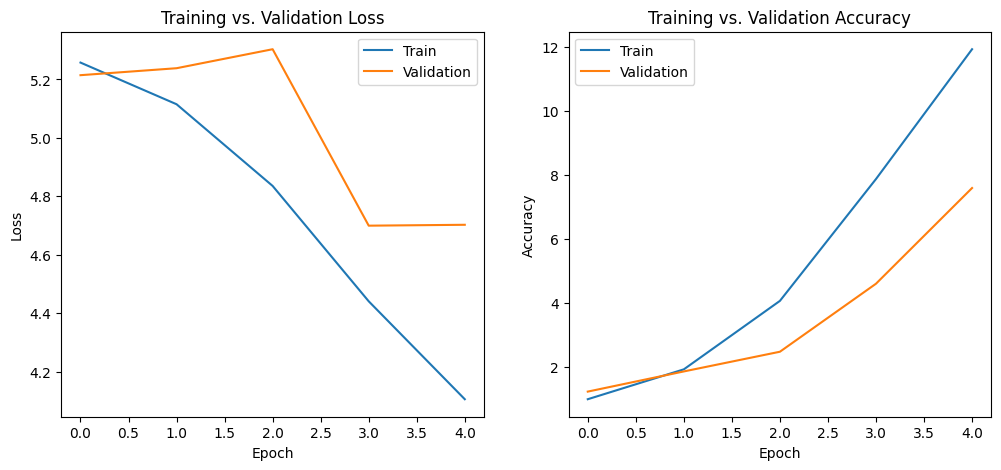

Accuracy: 0.0730
F1 Score: 0.0537
Precision: 0.1146
Recall: 0.0730
time: 1min 34s (started: 2025-03-07 14:47:27 +02:00)


/Users/yoavgal/code/car-classification/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
epochs=5 # 100 
lr=0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(grayscale_cnn_exp1_model.parameters(), lr)

train_loss, val_loss, train_acc, val_acc = training_loop(
    grayscale_cnn_exp1_model, optimizer, criterion, epochs, train_loader, val_loader, is_clip=True ,none_blocking=True)

visualize_results(train_loss, val_loss, train_acc, val_acc)
generate_classification_report(grayscale_cnn_exp1_model, test_loader, device)

# Experiment 2: Depthwise Separable Convolutions

Architecture:
*   **Depthwise Separable Convolutions:** Utilizes depthwise separable convolutions as the primary building block, drastically reducing the number of parameters and operations compared to standard convolutions. This is the key to its small size - inspiered by moblieNet.

*   **Strategic Downsampling:** Uses a combination of strided convolutions and max pooling to progressively reduce spatial dimensions, balancing feature extraction with computational efficiency.

*    **Regularization:** Includes Batch Normalization and Dropout to improve training stability and prevent overfitting, important given the from-scratch training and limited data.

*    **Global Average Pooling:** Employs global average pooling before the final layer to significantly reduce the number of parameters and add translational invariance.



In [26]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1)
        self.bn_dw = nn.BatchNorm2d(in_channels)
        self.bn_pw = nn.BatchNorm2d(out_channels)


    def forward(self, x):
        x = F.relu(self.bn_dw(self.depthwise(x)))
        x = F.relu(self.bn_pw(self.pointwise(x)))
        return x

class SmallCNN(nn.Module):
    def __init__(self, num_classes=196):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        self.block1 = self._make_block(8, 16)
        self.block2 = self._make_block(16, 32)
        self.block3 = self._make_block(32, 64)
        self.block4 = self._make_block(64, 128)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def _make_block(self, in_channels, out_channels):
        return nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels, 3, stride=1, padding=1),
            DepthwiseSeparableConv(out_channels, out_channels, 3, stride=1, padding=1),
            nn.MaxPool2d(2,2)
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc(x)
        return x

small_cnn_exp_2 = SmallCNN()
small_cnn_exp_2.to(device)
print_params_count(small_cnn_exp_2)

Total number of parameters: 63780
Total number of trainable parameters: 63780
time: 110 ms (started: 2025-03-07 15:33:28 +02:00)


Epoch [1/20], Loss: 3.0595, Validation Loss: 2.6734, Validation Accuracy: 31.34%


Epoch [2/20], Loss: 3.0773, Validation Loss: 2.7552, Validation Accuracy: 29.61%


Epoch [3/20], Loss: 3.0592, Validation Loss: 2.5757, Validation Accuracy: 33.61%


Epoch [4/20], Loss: 3.0611, Validation Loss: 2.7096, Validation Accuracy: 31.26%


Epoch [5/20], Loss: 3.0616, Validation Loss: 2.7766, Validation Accuracy: 29.23%


Epoch [6/20], Loss: 3.0529, Validation Loss: 2.6261, Validation Accuracy: 32.56%


Epoch [7/20], Loss: 3.0478, Validation Loss: 2.6693, Validation Accuracy: 32.19%


Epoch [8/20], Loss: 3.0584, Validation Loss: 2.5998, Validation Accuracy: 32.98%


Epoch [9/20], Loss: 3.0420, Validation Loss: 2.6693, Validation Accuracy: 31.75%


Epoch [10/20], Loss: 3.0484, Validation Loss: 2.6645, Validation Accuracy: 31.53%


Epoch [11/20], Loss: 3.0339, Validation Loss: 2.5796, Validation Accuracy: 33.25%


Epoch [12/20], Loss: 3.0324, Validation Loss: 2.7093, Validation Accuracy: 31.38%


Epoch [13/20], Loss: 3.0344, Validation Loss: 2.6595, Validation Accuracy: 32.35%


Epoch [14/20], Loss: 3.0344, Validation Loss: 2.5888, Validation Accuracy: 33.89%


Epoch [15/20], Loss: 3.0308, Validation Loss: 2.6489, Validation Accuracy: 32.38%


Epoch [16/20], Loss: 3.0130, Validation Loss: 2.5673, Validation Accuracy: 34.01%


Epoch [17/20], Loss: 3.0200, Validation Loss: 2.5866, Validation Accuracy: 34.02%


Epoch [18/20], Loss: 3.0188, Validation Loss: 2.5607, Validation Accuracy: 33.26%


Epoch [19/20], Loss: 3.0143, Validation Loss: 2.6973, Validation Accuracy: 30.05%


Epoch [20/20], Loss: 3.0083, Validation Loss: 2.5824, Validation Accuracy: 33.03%


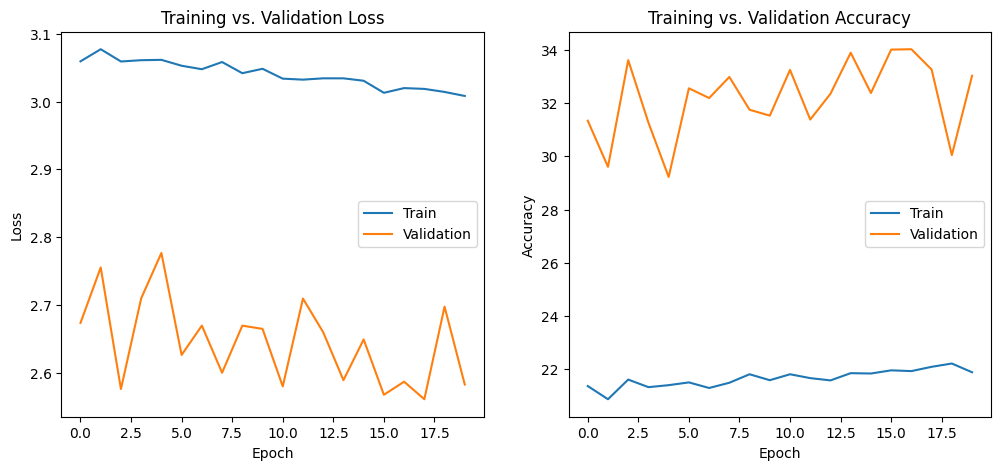

Accuracy: 0.3084
F1 Score: 0.3020
Precision: 0.3452
Recall: 0.3084
time: 8min 25s (started: 2025-03-07 16:22:23 +02:00)


/Users/yoavgal/code/car-classification/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
epochs=20
lr=0.02

optimizer = optim.Adam(small_cnn_exp_2.parameters(), lr)  # Adjust learning rate
criterion = nn.CrossEntropyLoss()

train_loss, val_loss, train_acc, val_acc = training_loop(
    small_cnn_exp_2, optimizer, criterion, epochs, train_loader, val_loader, is_clip=True ,none_blocking=True)

visualize_results(train_loss, val_loss, train_acc, val_acc)
generate_classification_report(small_cnn_exp_2, test_loader, device)

# EXP 3.1

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1)
        self.bn_dw = nn.BatchNorm2d(in_channels)
        self.bn_pw = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn_dw(self.depthwise(x)))
        x = F.relu(self.bn_pw(self.pointwise(x)))
        return x

class FasterCNN(nn.Module):  # Renamed for clarity
    def __init__(self, num_classes=196, use_global_max_pool=False):
        super(FasterCNN, self).__init__()
        self.use_global_max_pool = use_global_max_pool

        # Aggressive downsampling in the first layer
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)  # Initial downsampling
        self.bn1 = nn.BatchNorm2d(8)
        self.block1 = self._make_block(8, 16, stride=2)  # Downsample again
        self.block2 = self._make_block(16, 24, stride=2) # Fewer channels, fewer blocks
        self.block3 = self._make_block(24, 32, stride=2)  # Downsample in blocks

        # Choose pooling type
        if self.use_global_max_pool:
          self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        else:
          self.global_pool = nn.AdaptiveAvgPool2d((1, 1))


        self.dropout = nn.Dropout(0.3)  # Less dropout, faster training (regularization tradeoff)
        self.fc = nn.Linear(32, num_classes)  # Adjust input features


    def _make_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels, 3, stride=stride, padding=1),  # Stride here
            DepthwiseSeparableConv(out_channels, out_channels, 3, stride=1, padding=1),
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

small_CNN = FasterCNN(use_global_max_pool=True)
small_CNN.to(device)
print_params_count(small_CNN)

Total number of parameters: 11572
Total number of trainable parameters: 11572
time: 50.6 ms (started: 2025-03-07 17:07:07 +02:00)


Epoch [1/30], Loss: 5.4387, Validation Loss: 5.2744, Validation Accuracy: 0.88%


Epoch [2/30], Loss: 5.2766, Validation Loss: 5.2734, Validation Accuracy: 0.92%


Epoch [3/30], Loss: 5.2692, Validation Loss: 5.2622, Validation Accuracy: 1.01%


Epoch [4/30], Loss: 5.2528, Validation Loss: 5.2391, Validation Accuracy: 1.01%


Epoch [5/30], Loss: 5.2303, Validation Loss: 5.2192, Validation Accuracy: 1.14%


Epoch [6/30], Loss: 5.1993, Validation Loss: 5.1849, Validation Accuracy: 1.50%


Epoch [7/30], Loss: 5.1685, Validation Loss: 5.1548, Validation Accuracy: 1.61%


Epoch [8/30], Loss: 5.1423, Validation Loss: 5.1256, Validation Accuracy: 1.78%


Epoch [9/30], Loss: 5.1156, Validation Loss: 5.0934, Validation Accuracy: 2.05%


Epoch [10/30], Loss: 5.0809, Validation Loss: 5.0606, Validation Accuracy: 2.35%


Epoch [11/30], Loss: 5.0483, Validation Loss: 5.0258, Validation Accuracy: 2.46%


Epoch [12/30], Loss: 5.0145, Validation Loss: 4.9747, Validation Accuracy: 2.96%


Epoch [13/30], Loss: 4.9811, Validation Loss: 4.9305, Validation Accuracy: 3.20%


Epoch [14/30], Loss: 4.9455, Validation Loss: 4.9062, Validation Accuracy: 2.90%


Epoch [15/30], Loss: 4.9101, Validation Loss: 4.8726, Validation Accuracy: 3.18%


Epoch [16/30], Loss: 4.8641, Validation Loss: 4.8117, Validation Accuracy: 3.92%


Epoch [17/30], Loss: 4.8301, Validation Loss: 4.7624, Validation Accuracy: 4.21%


Epoch [18/30], Loss: 4.7902, Validation Loss: 4.7261, Validation Accuracy: 4.49%


Epoch [19/30], Loss: 4.7497, Validation Loss: 4.6771, Validation Accuracy: 4.71%


Epoch [20/30], Loss: 4.7070, Validation Loss: 4.6359, Validation Accuracy: 5.71%


Epoch [21/30], Loss: 4.6691, Validation Loss: 4.5861, Validation Accuracy: 6.16%


Epoch [22/30], Loss: 4.6323, Validation Loss: 4.5353, Validation Accuracy: 6.09%


Epoch [23/30], Loss: 4.5943, Validation Loss: 4.5034, Validation Accuracy: 6.34%


Epoch [24/30], Loss: 4.5660, Validation Loss: 4.4956, Validation Accuracy: 6.48%


Epoch [25/30], Loss: 4.5321, Validation Loss: 4.4549, Validation Accuracy: 7.09%


Epoch [26/30], Loss: 4.5069, Validation Loss: 4.4058, Validation Accuracy: 7.69%


Epoch [27/30], Loss: 4.4809, Validation Loss: 4.3815, Validation Accuracy: 7.64%


Epoch [28/30], Loss: 4.4473, Validation Loss: 4.3355, Validation Accuracy: 8.79%


Epoch [29/30], Loss: 4.4297, Validation Loss: 4.3454, Validation Accuracy: 8.00%


Epoch [30/30], Loss: 4.4089, Validation Loss: 4.3805, Validation Accuracy: 7.60%


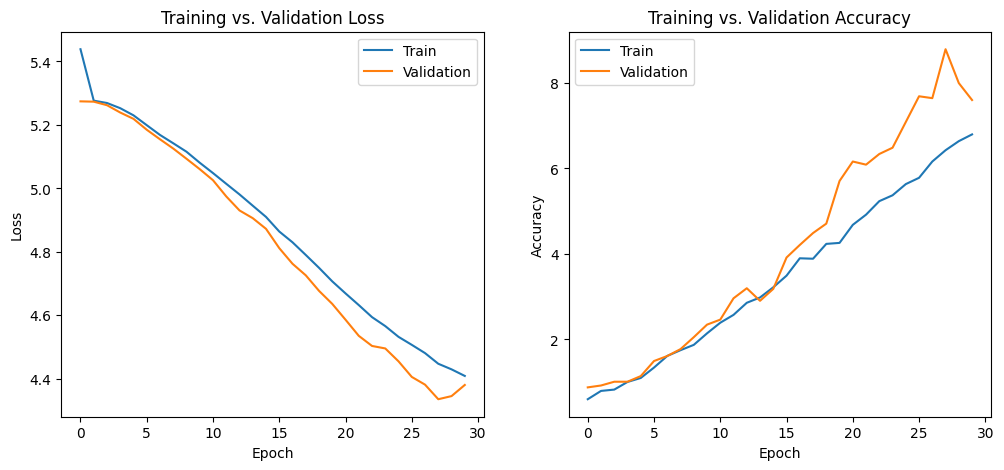

Accuracy: 0.0601
F1 Score: 0.0461
Precision: 0.0506
Recall: 0.0601
time: 7min (started: 2025-03-07 17:07:29 +02:00)


/Users/yoavgal/code/car-classification/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
epochs=30
lr=1e-3

optimizer = optim.AdamW(small_CNN.parameters(), lr=1e-3, betas=(0.9,0.999), weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)

train_loss, val_loss, train_acc, val_acc = training_loop(
    small_CNN, optimizer, criterion, epochs, train_loader, val_loader,scheduler=scheduler, is_clip=True,none_blocking=True)

visualize_results(train_loss, val_loss, train_acc, val_acc)
generate_classification_report(small_CNN, test_loader, device)

In [39]:
if torch.backends.mps.is_available():
    print(f"Driver allocated MPS memory: {torch.mps.driver_allocated_memory() / (1024**2):.2f} MB")
torch.mps.recommended_max_memory() / (1024**2)

Driver allocated MPS memory: 6175.34 MB


12288.015625

time: 29.9 ms (started: 2025-03-07 14:46:46 +02:00)


# Experiment 3: Advanced Techniques
In this experiment, we will:
- Implement advanced techniques such as data augmentation
- Explore different optimization strategies
- Experiment with ensemble methods
- Analyze the impact of these techniques on model performance

In [29]:
%pip install clip-openai

Note: you may need to restart the kernel to use updated packages.
time: 926 ms (started: 2025-03-07 13:49:56 +02:00)


In [30]:
import clip

time: 477 ms (started: 2025-03-07 13:49:57 +02:00)


In [31]:
def embed_tensor_clip(image_tensor, model, preprocess):
    image = preprocess(image_tensor).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features.cpu().numpy()

time: 22.4 ms (started: 2025-03-07 13:49:58 +02:00)


In [32]:
 images_tensor, labels_tensor = csv_to_tensors(
    'stanford_cars_train.csv',
    './content/images',
    output_size=(224, 224)
)

NameError: name 'csv_to_tensors' is not defined

time: 34.9 ms (started: 2025-03-07 13:49:58 +02:00)


In [ ]:
model, clip_preprocess = clip.load("ViT-B/32", device=device)

AttributeError: 'CLIP' object has no attribute 'load'

time: 29.1 ms (started: 2025-03-07 08:36:55 +02:00)


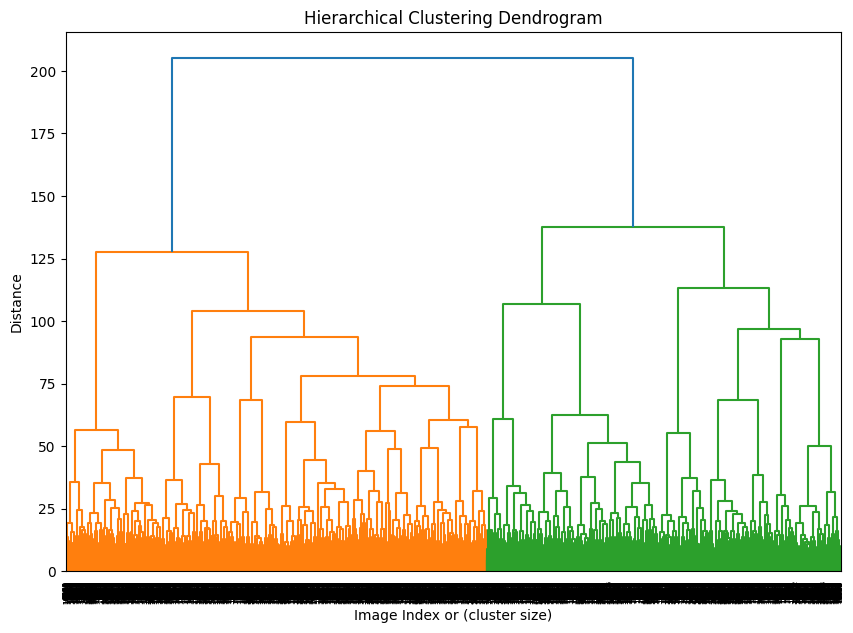

Label: 0, Indices: [162, 461, 521, 706, 772, 886, 945, 1276, 1660, 1831]...
Label: 1, Indices: [669, 690, 857, 1030, 1033, 1534, 1890, 2064, 2313, 2539]...
Label: 2, Indices: [1, 739, 1213, 1704, 1715, 1749, 1869, 2363, 2490, 2588]...
Label: 3, Indices: [391, 696, 919, 1263, 2123, 2239, 2273, 2912, 3050, 3101]...
Label: 4, Indices: [68, 150, 409, 423, 630, 699, 741, 1133, 1391, 1971]...
time: 1min 3s (started: 2025-03-07 01:57:40 +02:00)


In [ ]:
import torch
import clip
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

def to_rgb(image):
    if image.shape[0] == 1:
        return image.repeat(3, 1, 1)
    else:
        return image

image_features = []
batch_size = 256
with torch.no_grad():
    for i in range(0, images_tensor.shape[0], batch_size):
        batch = images_tensor[i:i + batch_size].to(device)
        batch = torch.stack([to_rgb(img) for img in batch]).to(device)
        batch_features = model.encode_image(batch)
        image_features.append(batch_features.cpu())

image_features = torch.cat(image_features)

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, compute_full_tree=True).fit(image_features)

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(10, 7))
plot_dendrogram(clustering, truncate_mode=None, p=10)
plt.xlabel("Image Index or (cluster size)")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

unique_labels = torch.unique(labels_tensor)
num_clusters_to_show = min(len(unique_labels), 5)

for label in unique_labels[:num_clusters_to_show]:
    indices = (labels_tensor == label).nonzero(as_tuple=True)[0]
    print(f"Label: {label}, Indices: {indices.tolist()[:10]}...")

In [ ]:
for label in unique_labels:
    print(label)

tensor(0)
tensor(1)
tensor(2)
tensor(3)
tensor(4)
tensor(5)
tensor(6)
tensor(7)
tensor(8)
tensor(9)
tensor(10)
tensor(11)
tensor(12)
tensor(13)
tensor(14)
tensor(15)
tensor(16)
tensor(17)
tensor(18)
tensor(19)
tensor(20)
tensor(21)
tensor(22)
tensor(23)
tensor(24)
tensor(25)
tensor(26)
tensor(27)
tensor(28)
tensor(29)
tensor(30)
tensor(31)
tensor(32)
tensor(33)
tensor(34)
tensor(35)
tensor(36)
tensor(37)
tensor(38)
tensor(39)
tensor(40)
tensor(41)
tensor(42)
tensor(43)
tensor(44)
tensor(45)
tensor(46)
tensor(47)
tensor(48)
tensor(49)
tensor(50)
tensor(51)
tensor(52)
tensor(53)
tensor(54)
tensor(55)
tensor(56)
tensor(57)
tensor(58)
tensor(59)
tensor(60)
tensor(61)
tensor(62)
tensor(63)
tensor(64)
tensor(65)
tensor(66)
tensor(67)
tensor(68)
tensor(69)
tensor(70)
tensor(71)
tensor(72)
tensor(73)
tensor(74)
tensor(75)
tensor(76)
tensor(77)
tensor(78)
tensor(79)
tensor(80)
tensor(81)
tensor(82)
tensor(83)
tensor(84)
tensor(85)
tensor(86)
tensor(87)
tensor(88)
tensor(89)
tensor(90)
tensor(91

# Save Model
In this section, we will:
- Save the best performing model
- Document the model architecture and hyperparameters
- Prepare the model for deployment or future use

In [512]:
model_filename = "small_cnn_exp_2"
save_best_model(small_cnn_exp_2,model_filename)

Model saved to /Users/yoavgal/code/car-classification/CNN-notebook/./saved_models/small_cnn_exp_2
time: 60 ms (started: 2025-03-07 00:38:52 +02:00)


# Test Model
In this section, we will:
- Evaluate the final model on the test dataset
- Generate classification reports and confusion matrices
- Visualize the model's predictions on sample images
- Discuss the strengths and weaknesses of our approach